# Exploring MitoCheck data 

In this notebook, we explore the dataset to assess its size and establish assumptions before training our model. We observe that both the negative and positive controls contain the largest amount of cells, while the labeled dataset for training is relatively small. Consequently, we need to implement a downsampling method for the controls to incorporate them into the dataset. Additionally, we identify label imbalances within the data, suggesting the need for additional stratification steps when splitting our dataset.

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src import analysis_utils

sys.path.append("../../")  # noqa

In [2]:
# setting up paths
data_dir = pathlib.Path("../../data").resolve(strict=True)
mitocheck_data_path = (data_dir / "raw/mitocheck_data/normalized_data").resolve(
    strict=True
)

# creating
processed_dir = (data_dir / "processed").resolve()
processed_dir.mkdir(exist_ok=True)

## Dataset Loading Procedure

In this section, we load three essential datasets: negative controls, positive controls, and training data.

- **Negative Controls:** These cells are treated with scramble siRNA, indicating no specific gene inhibition. Hence, no significant effects are expected.
- **Positive Controls:** These cells are treated with siRNA targeting specific genes, providing a basis for comparison and validation.

  - **COPB1 siRNA:** COPB1 is involved in intracellular protein trafficking. When targeted by siRNA, reduced COPB1 levels disrupt protein transport, potentially affecting secretion, membrane integrity, and organelle homeostasis.

  - **INCENP siRNA:** INCENP regulates cell division. siRNA against INCENP leads to disrupted mitosis, causing defects in chromosome alignment, kinetochore-microtubule attachment, and cytokinesis, potentially resulting in cell death or genomic instability.

  - **KIF11 siRNA:** KIF11 mediates mitotic spindle formation. Targeting KIF11 with siRNA impairs spindle assembly and chromosome segregation, leading to mitotic arrest, aberrant chromosome segregation, and potential cell cycle defects or cell death.

- **Training Data:** These are labeled datasets meticulously curated from the Mitocheck consortium, serving as the foundation for our analysis.

The shapes of the dataframe are in (number of cells, morphological features) format


In [3]:
# loading in dataset
neg_df = pd.read_parquet(mitocheck_data_path / "negative_control_data.parquet")
pos_df = pd.read_parquet(mitocheck_data_path / "positive_control_data.parquet")
training_df = pd.read_parquet(mitocheck_data_path / "training_data.parquet")

In [4]:
# looking at the sizes of th dataset
print("Negative control dataset is:", neg_df.shape)
print("Positive control dataset is:", pos_df.shape)
print("training dataset is:", training_df.shape)

Negative control dataset is: (779993, 1448)
Positive control dataset is: (612059, 1448)
training dataset is: (2916, 1451)


In [5]:
print("siRNA's used for negative controls:", neg_df["Metadata_Gene"].unique())
print("siRNA's used for positive controls:", pos_df["Metadata_Gene"].unique())

siRNA's used for negative controls: ['negative control']
siRNA's used for positive controls: ['COPB' 'ENSG00000149503' 'KIF11']


In [6]:
print("Number of plates in the neg dataset", len(neg_df["Metadata_Plate"].unique()))
print("Number of plates in the pos dataset", len(pos_df["Metadata_Plate"].unique()))
print(
    "Number of plates in the training dataset",
    len(training_df["Metadata_Plate"].unique()),
)

Number of plates in the neg dataset 510
Number of plates in the pos dataset 510
Number of plates in the training dataset 67


## Exploring The training Dataset


Let look what are the treatments present in the training dataset


In [7]:
# Looking at the metadata about each individual cells within the training data
training_meta, training_features = analysis_utils.split_mitocheck_features(training_df)
training_df[training_meta].head()

,Unnamed: 0,Mitocheck_Phenotypic_Class,Cell_UUID,Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Frame,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,Metadata_Gene,Metadata_Gene_Replicate,Metadata_Object_Outline
0,0,Large,21da27ab-873a-41f4-ab98-49170cae9a2d,397,618,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,[[396 595]\n [395 596]\n [394 596]\n [393 596]...
1,1,Large,82f7949b-4ea2-45c8-8dd9-7854caf49077,359,584,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,[[361 563]\n [360 564]\n [359 564]\n [358 564]...
2,2,Large,cec7234f-fe35-4411-aded-f8112bb31219,383,685,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,[[379 662]\n [378 663]\n [377 663]\n [376 663]...
3,3,Large,43d9e7c9-c9ec-45ce-8820-048bfb896989,932,532,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,KIF14,1,[[923 515]\n [922 516]\n [921 516]\n [920 516]...
4,4,Large,63ce6652-338e-4afd-9c77-dbc0e903bf92,477,130,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,KIF14,1,[[465 108]\n [464 109]\n [464 110]\n [463 111]...


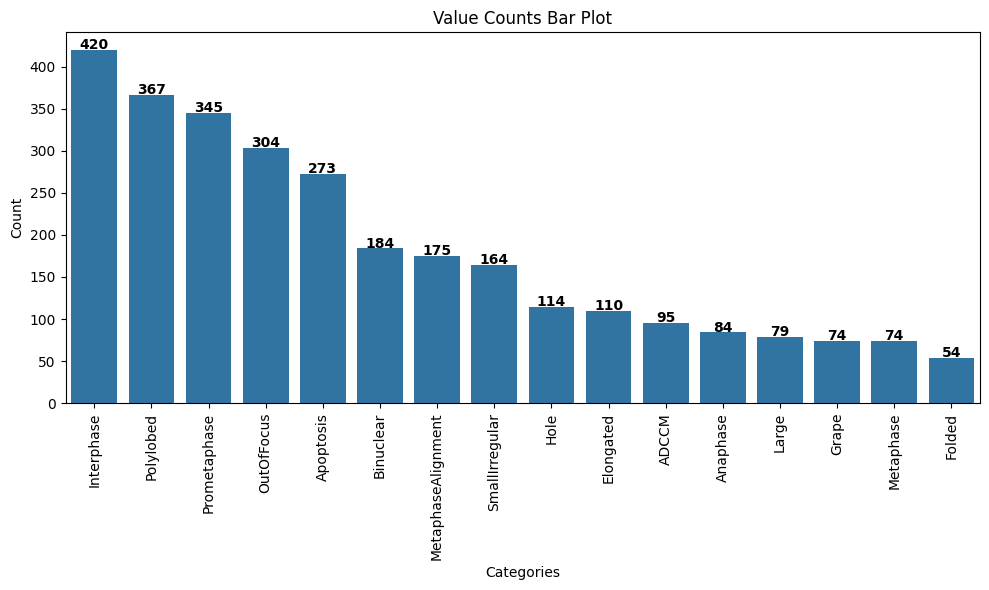

In [8]:
# let see the amount of labels we have
phenotype_counts = training_df["Mitocheck_Phenotypic_Class"].value_counts()

plt.figure(figsize=(10, 6))  # Set the figure size (optional)
sns.barplot(x=phenotype_counts.index, y=phenotype_counts.values)
plt.title("Value Counts Bar Plot")
plt.xlabel("Categories")
plt.ylabel("Count")

# Add value numbers on top of each bar
for i, v in enumerate(phenotype_counts.values):
    plt.text(i, v + 1, str(v), ha="center", fontweight="bold", color="black")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

> This bar plot illustrates the distribution of cellular states present in our training dataset. It's evident that there's an imbalance among the classes, which necessitates additional steps during the creation of our data splits.